In [2]:
from glob import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
survey = 'PanStarrs'
# survey = 'Gaia'
# survey = 'ZTF'
results = glob('../04_ComputeMetrics/{}/Results/*'.format(survey))
results.sort()
results

['../04_ComputeMetrics/PanStarrs/Results/Fold_1_Results.dat',
 '../04_ComputeMetrics/PanStarrs/Results/Fold_2_Results.dat',
 '../04_ComputeMetrics/PanStarrs/Results/Fold_3_Results.dat',
 '../04_ComputeMetrics/PanStarrs/Results/Fold_4_Results.dat',
 '../04_ComputeMetrics/PanStarrs/Results/Fold_5_Results.dat',
 '../04_ComputeMetrics/PanStarrs/Results/Fold_6_Results.dat',
 '../04_ComputeMetrics/PanStarrs/Results/Fold_7_Results.dat']

In [4]:

df = pd.concat([pd.read_csv(result) for result in results], axis=0)
columns = df.columns
params = ['_'.join(i.split('_')[1:]) for i in columns if 'Pred_' in i]
df = df[[p+i for i in params for p in ['Pred_','True_']]]

In [5]:
df

,Pred_T_eff,True_T_eff,Pred_Radius,True_Radius
84300158481827892,7270.9070,7396.3037,13.418306,-1.0
74163190788076994,6234.9897,5955.7760,8.359905,-1.0
103253008374854869,5767.8823,6638.7150,13.194317,-1.0
74022884304620926,6730.8330,7203.6280,13.048449,-1.0
131542740608734400,5624.9033,6253.8680,8.247026,-1.0
...,...,...,...,...
135653130185616420,6612.7540,5892.3470,6.808911,-1.0
142522950423995137,3830.6430,-1.0000,71.207860,-1.0
122941626613909670,7144.0740,6629.6436,-5.045709,-1.0
97812927510537707,5902.5625,5153.7363,3.454159,-1.0


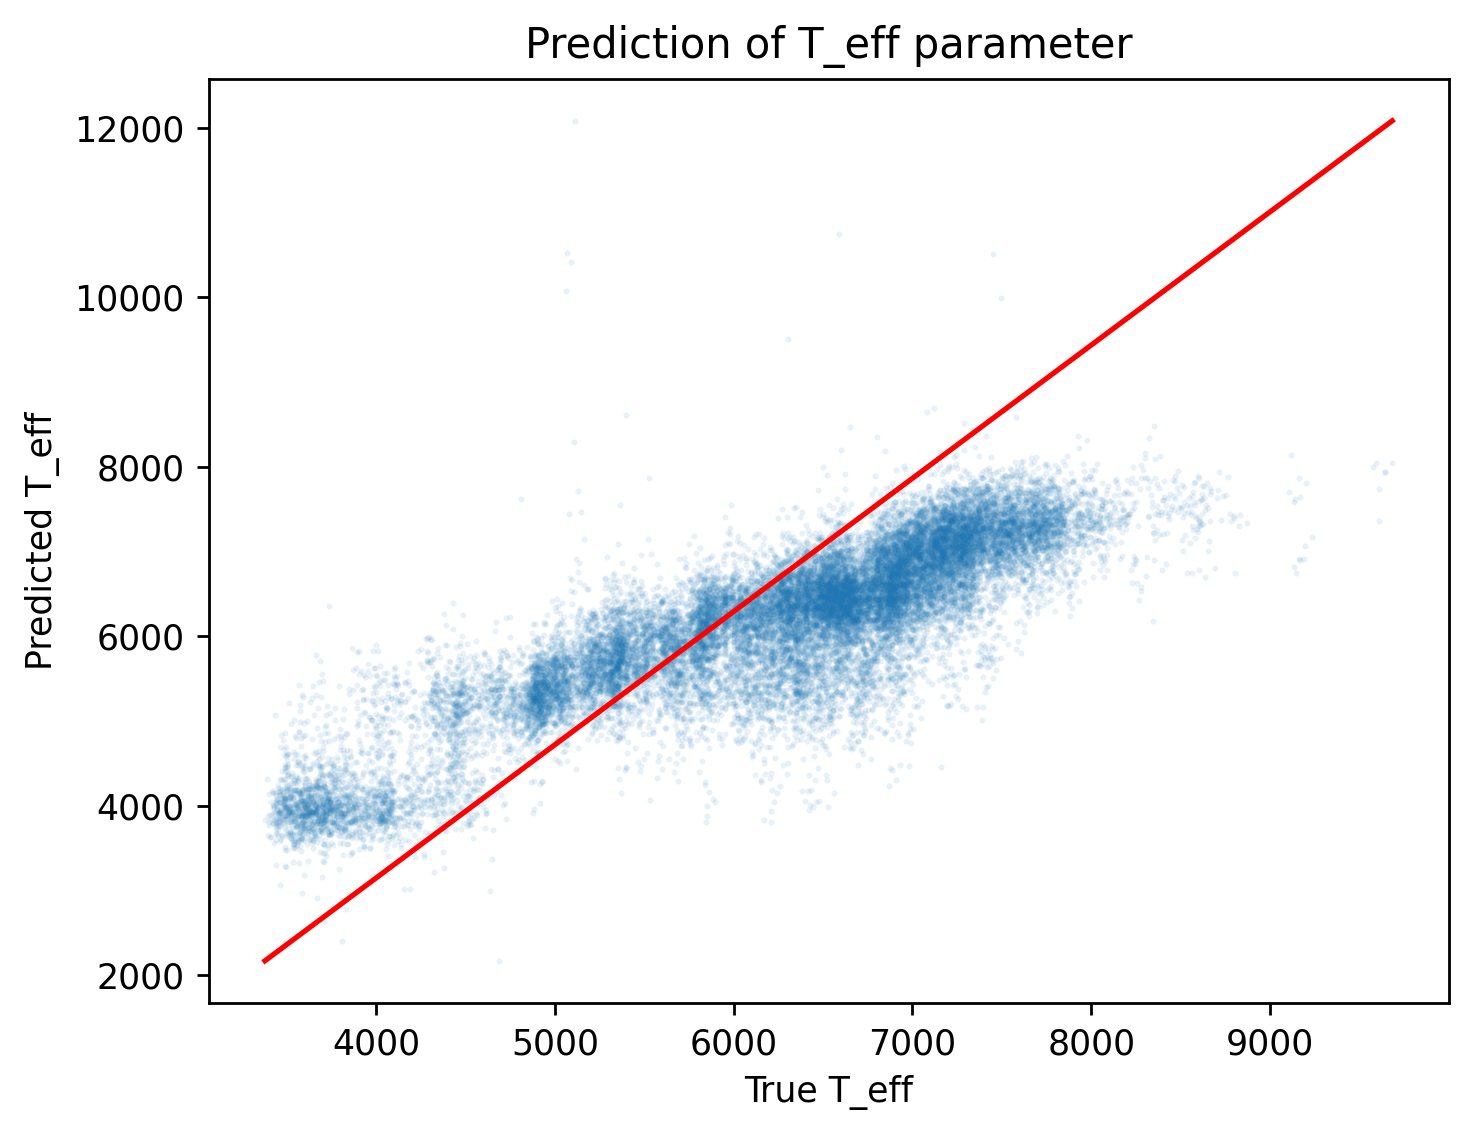

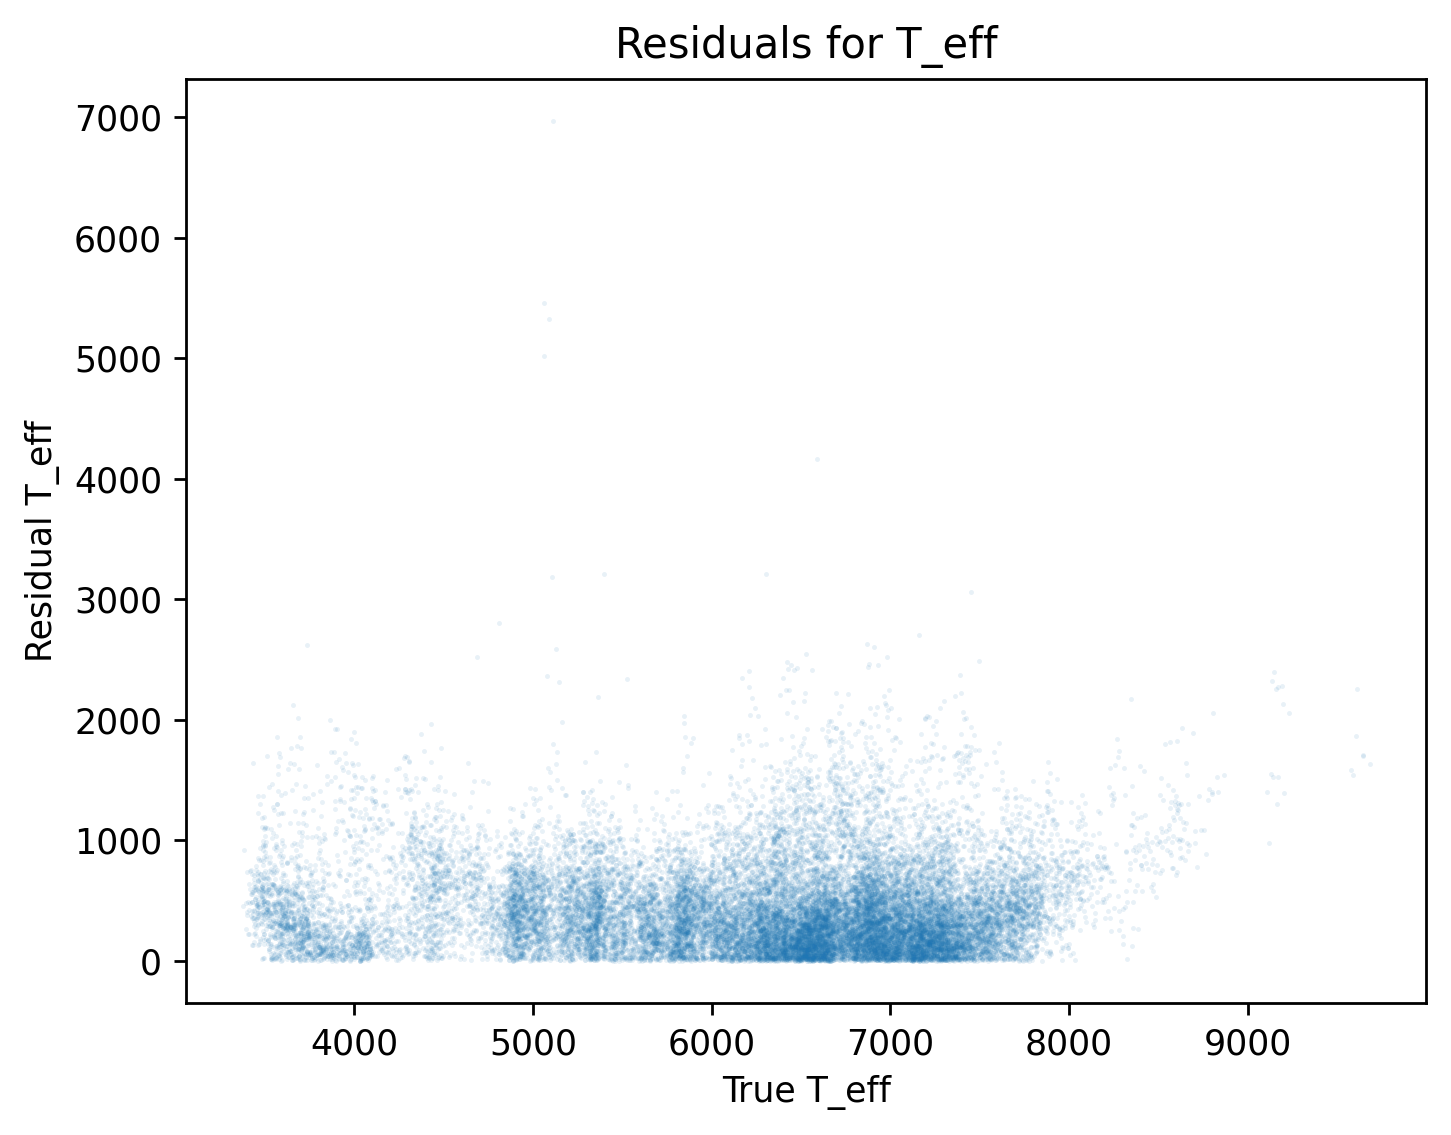

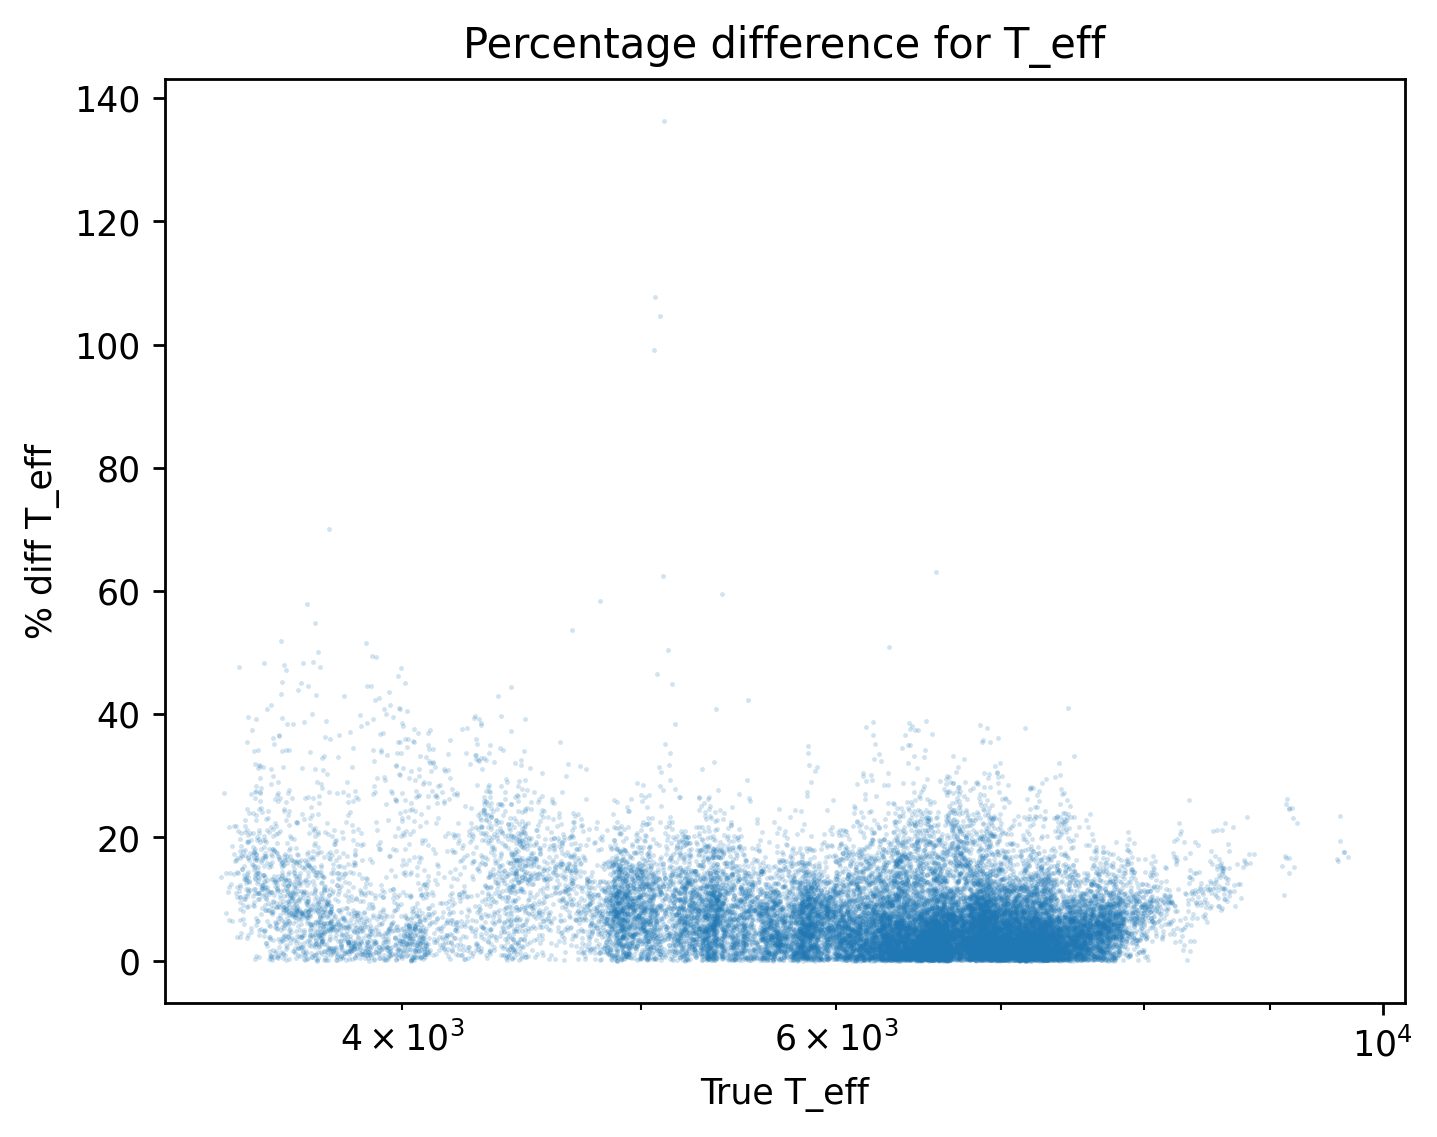

In [10]:

for param in params:
    true = 'True_'+param
    pred = 'Pred_'+param
    sel = df[[pred,true]][df[true]>0]

    # Plot true vs real
    plt.figure(dpi=250)
    plt.scatter(sel[true], sel[pred], s=3, alpha=0.1, lw=0)
    plt.plot([sel[true].min(),sel[true].max()],[sel[pred].min(),sel[pred].max()], c='r')
    plt.ylabel('Predicted '+param )
    plt.xlabel('True '+param)
    plt.title('Prediction of {} parameter'.format(param))
    plt.show()

    # Plot RSE
    # rse = np.sqrt(np.power(sel[true]-sel[pred],2))
    rse = np.abs(sel[true]-sel[pred])
    plt.figure(dpi=250)
    plt.scatter(sel[true], rse, s=2, lw=0, alpha=0.1)
    # plt.plot([0,160],[0,160], c='r')
    plt.xlabel('True '+param )
    plt.ylabel('Residual '+param)
    plt.title('Residuals for {}'.format(param))
    plt.show()

    # Plot of % difference
    perc_dif = 100*np.abs(sel[true]-sel[pred])/sel[true]
    plt.figure(dpi=250)
    plt.scatter(sel[true], perc_dif, s=2, lw=0, alpha=0.2)
    # plt.plot([0,160],[0,160], c='r')
    plt.xlabel('True '+param )
    plt.xscale('log')
    plt.ylabel('% diff '+param)
    plt.title('Percentage difference for {}'.format(param))
    plt.show()
    break

In [26]:
test_df = pd.DataFrame(sel[true])
test_df = test_df.assign(p_diff=perc_dif)
test_df.head()

,True_T_eff,p_diff
84300158481827892,7396.3037,1.695397
74163190788076994,5955.7760,4.688116
103253008374854869,6638.7150,13.117489
74022884304620926,7203.6280,6.563290
131542740608734400,6253.8680,10.057211


In [60]:
n_bins =20
param_range = test_df[true].max()-test_df[true].min()
step = param_range/n_bins
bins = np.arange(test_df[true].min(),test_df[true].max(), step)

centers = []
datas = []
for i in range(1,bins.shape[0]):
    b1 = test_df[true]>=bins[i-1]
    b2 = test_df[true]<=bins[i]
    b = np.logical_and(b1,b2)
    sel_ = test_df[b]
    
    mid_bin = round(bins[i-1]+(bins[i]-bins[i-1])/2, 2)
    centers.append(str(mid_bin))
    datas.append(sel_['p_diff'])
    # plt.boxplot(sel_['p_diff'],labels=[str(mid_bin)])
    # break
# plt.show()

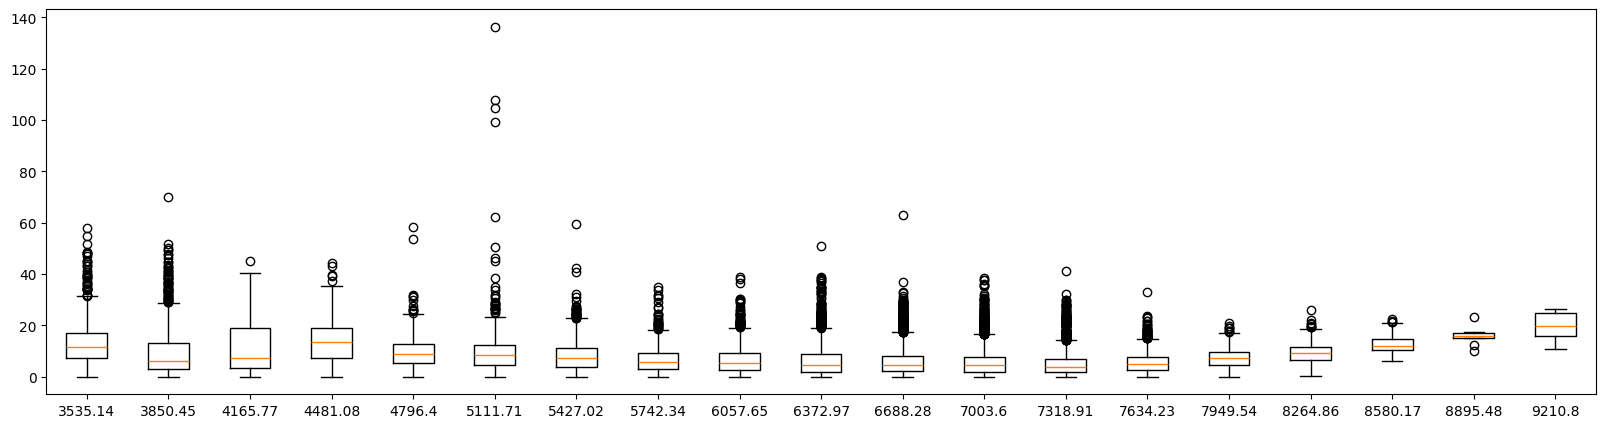

In [67]:
plt.figure(figsize=(20,5))
plt.boxplot(datas, labels=centers)
plt.show()

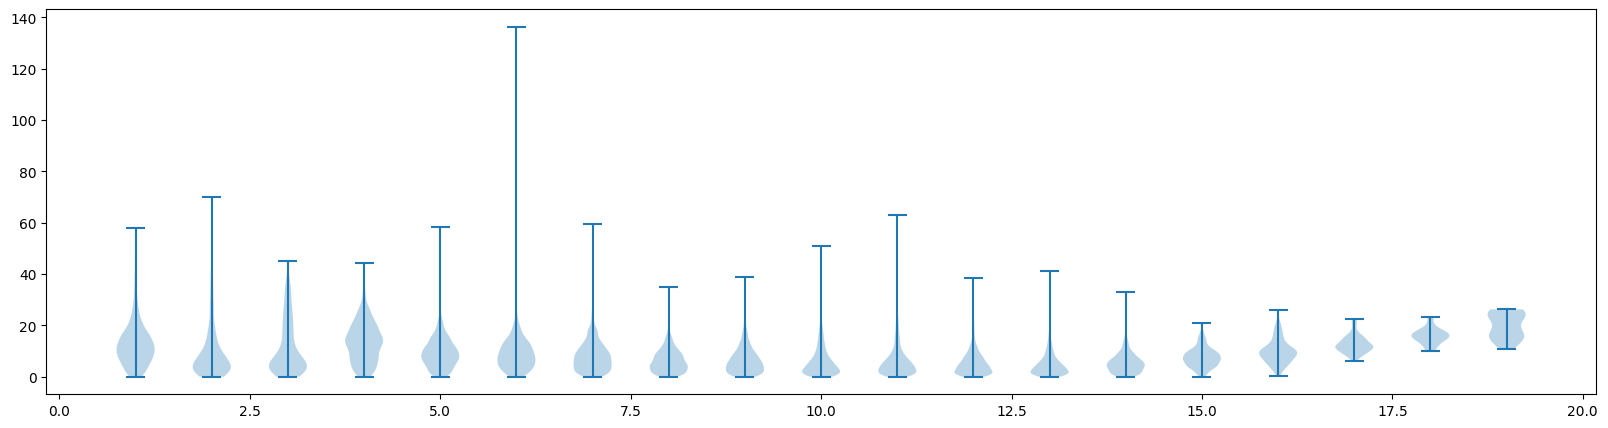

In [66]:
plt.figure(figsize=(20,5))
plt.violinplot(datas )
plt.show()

In [69]:
sel_

,True_T_eff,p_diff
80541871244341099,9163.170,14.162675
95080843559072112,9191.584,24.800557
80541871244341099,9131.617,17.005395
95080843559072112,9159.740,24.601643
95080843559072112,9134.857,25.397186
80541871244341099,9106.953,15.419054
95080843559072112,9194.953,23.148540
80541871244341099,9166.823,16.604810
80541871244341099,9138.197,16.650905
95080843559072112,9166.239,24.802790


Plot predicted vs real

Plot RMSE

Plot residuals

In [77]:
sel[residual>100][pred]

82743016458142927     1.553326
168002581351312516    3.368531
72192811727849189     2.958683
142452759686140873    2.780368
150972582711008157    3.708347
                        ...   
91002939225880848     2.293423
74412802212565969     2.722908
114091867420871949    2.588575
80421305712133292     2.417079
75432811076913200     2.867074
Name: Pred_Radius, Length: 1077, dtype: float64

In [80]:
sel[residual<100]

,Pred_Radius,True_Radius
87262899750438729,2.001917,4.392753
80521624631607856,2.934649,2.621521
102781342434621996,3.223143,2.399150
86432951986193645,2.329052,2.021120
85352668912337605,34.572320,33.309670
...,...,...
83152573653988966,3.741451,3.016954
119432729145323483,2.139428,5.744381
114973009413308331,2.861603,2.278297
117942891801648788,94.697030,66.032020
